# 2. Quantum k-SAT
We implement an algorithm to solve an arbitrary k-SAT problem!

A general function $F(x)$ for the k-SAT problem looks like:
$$F(x_1, ..., x_n) = \bigcap_{i=1}^m C_i$$ 
with each $C_i$ is a union of atmost $k$ variables or their negations.

We first rephrase the problem as a search problem: An $x = (x_1, x_2, \cdots x_n) \in \{0, 1\}^n$ such that $F(x) = 1$ is called a solution to the search problem. The search problem is to find a solution $x$. We employ Grover's method to solve it.

Setup:
The state $x$ is encoded using $n$ qubits with the $i^{\text{th}}$ qubit being in the state $|1\rangle$ if $x_i$ is 1 and in $|0\rangle$ otherwise. We also add one more qubit to the $n$ qubits in order to double the solution space. We also have $m$ qubits labelled $C_0 \cdot C_{m-1}$ as part of the oracle workspace. Finally, we have one qubit in the state $|-\rangle$ to get the $(-1)^{F(x)}$ effect from the Oracle.

Now for the oracle itself. It computes $F(x)$ from the $C_i$'s using an AND gate(implemented below), where each $C_i$ gate is implemented using an OR gate. Note that we also do some cleanup after computing F(x)(in particular, we uncompute the $C_i$'s) to reuse the workspace(aka the $C_i$'s) qubits for the (possibly) next iteration. Finally, we augment this oracle to the qubit with index n with a couple of $X$ gates to construct the final augmented oracle.

In [168]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.circuit.library.standard_gates import ZGate
sim = Aer.get_backend('aer_simulator')

import numpy as np
from IPython.display import display, Math

In [141]:
def AND(ckt: QuantumCircuit, qubits: list, ans_index: int):
    """computes the AND of the qubits with indices in the iterable qubits and stores the answer in(adds the answer to) the qubit with index ans_index"""
    #print(qubits)
    ckt.mcx(qubits, ans_index)
    return ckt

In [142]:
def OR(ckt: QuantumCircuit, qubits: list, toNOT: list, ans_index: int):
    """computes the OR of the qubits with indices in the iterable qubits and stores the answer in the qubit with index ans_index. The other parameter toNOT is an optimization: it tells us which qubits are NOT-ted in the union/OR. So basically we compute the NOTs and the OR in one sweep."""
    # Idea: We use that union(A_i) = (AND(A_i^c))^c. The AND is very easily implemented using the multi-controlled X gate.
    #print(list(zip(qubits, toNOT)))
    for index, qubit in enumerate(qubits):
        if not toNOT[index]: ckt.x(qubit)
    AND(ckt, qubits, ans_index)
    for index, qubit in enumerate(qubits): # restore the values of the qubits which had been X-ed.
        if not toNOT[index]: ckt.x(qubit) 
    ckt.x(ans_index)
    return ckt

In [143]:
def oracle(n: int, function: list[list[int]]):
    # The - denotes a NOT being taken. The function F* is represented as [[1, -2], [3, 4, -1], [2, -5]].
    ckt = QuantumCircuit(n + len(function) + 1) 
    # compute the C_i's.
    for i, C_i in enumerate(function):
        ckt = OR(ckt, qubits=[abs(qubit) - 1 for qubit in C_i], toNOT=[(qubit < 0) for qubit in C_i], ans_index=n + i)
        #ckt.barrier()
        
    # compute F(x) and xor it to the last qubit
    ckt = AND(ckt, list(range(n, n + len(function))), n + len(function))
    #ckt.barrier()
    
    # uncompute the C_is to reuse workspace for next iteration
    for i, C_i in enumerate(reversed(function)):
        ckt.x(n + len(function)-1-i) # i still goes 0 to len(function)-1, only C_i's are reversed.
        for qubit in C_i:
            if qubit > 0: ckt.x(qubit-1)
        ckt = AND(ckt, [abs(qubit) - 1 for qubit in C_i], n + len(function)-1-i)
        for qubit in C_i:
            if qubit > 0: ckt.x(qubit-1)
        #ckt.barrier()

    return ckt.to_gate(label=" oracle(f) ")

def augmented_oracle(n: int, oracle, f: list[list[int]]):
    """returns an Augmented oracle on n qubits(incl the dummy qubit) with len(f) workspace qubits. 1 more qubit to store answer."""
    c = QuantumCircuit(n + len(f) + 1)
    c.x(n-1)
    c.append(oracle(n-1, f).control(num_ctrl_qubits=1), [n-1] + list(range(n-1)) + list(range(n, n + len(f) + 1)))
    c.x(n-1)
    return c

In [145]:
def conditional_phase_shift(n: int):
    ckt = QuantumCircuit(n)
    ckt.x(range(n))
    ckt = ckt.compose(ZGate().control(num_ctrl_qubits=n-1))
    ckt.x(range(n))
    return ckt#.to_gate(label="Phase\nShift")

def grover_iteration(ckt: QuantumCircuit, n: int, oracle, f, augmented:bool = True):
    
    if augmented: ckt = ckt.compose(augmented_oracle(n, oracle, f))
    else: ckt = ckt.compose(oracle(n, f))
    ckt.barrier()
    ckt.h(range(n))
    ckt = ckt.compose(conditional_phase_shift(n))
    ckt.h(range(n))
    return ckt

In [146]:
# original solution with no augmentation -> would not work if M >= N/2.
def solve(n: int, oracle, f, M: int):
    ckt = QuantumCircuit(n + len(f) + 1, n)
    
    N = 2**n
    theta = 2*np.arcsin(np.sqrt(M/N))
    assert(theta < np.pi/2)
    print("theta is approximately", round(theta*180/np.pi), "degrees.")
    iterations = round(np.pi/(2*theta) - 0.5)
    print(f"number of iterations(k) is {iterations}")
    
    # initialize
    ckt.h(range(n))
    ckt.x(n + len(f)); ckt.h(n + len(f)) # get the last qubit into |-\rangle
    ckt.barrier()
    
    # iterate
    for _ in range(iterations):
        ckt = grover_iteration(ckt, n, oracle, f, augmented=False)
        ckt.barrier()
    
    # measure
    ckt.measure(range(n), range(n))

    possible_solutions = sim.run(transpile(ckt, sim), shots=4096).result().get_counts()
    # return ckt, possible_solutions
    possible_solutions = [(int(key, 2), value) for key, value in possible_solutions.items()]
    possible_solutions = sorted(possible_solutions, key=lambda item: item[1], reverse=True)

    return ckt, possible_solutions

In [147]:
# takes care of augmentation as well, and can successfully solve any k-SAT!
def solve(n: int, oracle, f, M: int):
    augmented = (M >= np.ceil(2**(n-1))) # M >= N/2 = 2**n/2 = 2**(n-1)
    if augmented:
        n += 1 # solve with the augmented oracle. Optimize on number of qubits used by solving with augmented only if M >= N/2.
    
    ckt = QuantumCircuit(n + len(f) + 1, n-1 if augmented else n)
    N = 2**n

    theta = 2*np.arcsin(np.sqrt(M/N)) # or np.arcsin(2*np.sqrt(M*(N-M))/N)
    assert(theta < np.pi/2)
    print("theta is approximately", round(theta*180/np.pi), "degrees.")
    iterations = round(np.pi/(2*theta) - 0.5)
    print(f"Number of iterations is {iterations}.")
    
    # initialize
    ckt.h(range(n)) # all n qubits are part of our state space(even if augmented!)
    ckt.x(n + len(f)); ckt.h(n + len(f)) # get the last qubit into |- >
    ckt.barrier()
    
    # iterate
    for _ in range(iterations):
        ckt = grover_iteration(ckt, n, oracle, f, augmented=augmented)
        ckt.barrier()
    
    # measure
    if augmented: 
        ckt.measure(range(n-1), range(n-1)) # we could but we don't need to measure the last qubit, since it is anyway 0(and x = 0x) in any solution 0x. So might as well just get x instead.
    else: 
        ckt.measure(range(n), range(n))
    
    possible_solutions = sim.run(transpile(ckt, sim), shots=4096).result().get_counts()
    possible_solutions = [(int(key, 2), value) for key, value in possible_solutions.items()]
    possible_solutions = sorted(possible_solutions, key=lambda item: item[1], reverse=True)

    return ckt, possible_solutions

In [ ]:
# help print the function in Latex onto the screen
def pprint(n: int, f: list[list[int]]) -> str:
    ans = 'f('
    if n == 1: ans += ') = '
    elif n == 2: ans += 'x_1, x_2) = '
    else: ans += f'x_1, ..., x_{n}) = '

    for C_i in f:
        ans += '('
        for elem in C_i:
            if elem < 0: ans += '\lnot '
            ans += f'x_{abs(elem)}'
            if elem != C_i[-1]:
                ans += ' \lor '
        ans += ')'
        if C_i != f[-1]: ans += ' \land '
    return ans

<IPython.core.display.Math object>


Running Algorithm...
theta is approximately 79 degrees.
Number of iterations is 1.


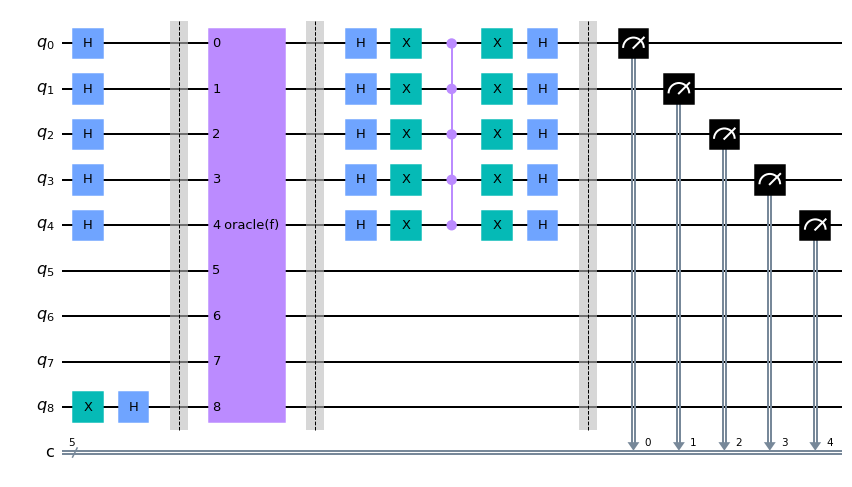

In [180]:
n = 5; f = [[1, -2], [3, 4, -1], [2, -5]]; M = 13
display(Math(pprint(n, f)))
print('\nRunning Algorithm...')
ckt, possible_solutions = solve(n, oracle, f, M=M)
ckt.draw("mpl")

In [181]:
print(possible_solutions)

[(12, 256), (11, 256), (27, 253), (4, 252), (0, 248), (8, 246), (31, 241), (15, 239), (23, 238), (13, 237), (9, 234), (7, 223), (5, 210), (25, 64), (22, 59), (16, 57), (29, 56), (17, 54), (6, 54), (1, 53), (18, 52), (21, 52), (28, 51), (30, 50), (2, 49), (24, 48), (14, 48), (3, 45), (10, 43), (26, 43), (19, 43), (20, 42)]


In [182]:
print("Solutions:", sorted(possible_solutions[i][0] for i in range(M)))

Solutions: [0, 4, 5, 7, 8, 9, 11, 12, 13, 15, 23, 27, 31]
